In [1]:
import awkward as ak
import numpy as np
import time
# print(coffea.__version__)
from coffea import util
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
import mplhep as hep
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

from plugins import *
from triggerProcessor import *
from dask.distributed import Client

In [3]:
# in_year = '2016APV'
# data_bool = True
# winterfell = True
# processor = triggerProcessor(year = in_year, trigger = 'AK8PFJet', data = data_bool)
# datastring = "JetHT" if processor.data == True else "QCDsim"
# if processor.data==False and winterfell:
#     filename = "QCD_flat.json"
# elif processor.data==False:
#     filename = "fileset_QCD.json"
# else:
#     filename = "datasets_UL_NANOAOD.json"
# result = runCoffeaJob(processor, jsonFile = filename, winterfell = winterfell, testing = False, year = processor.year, data = processor.data)
# with open('coffeaOutput/triggerAssignment_{}_{}_{}_NewHist.pkl'.format(datastring, processor.year, processor.trigger), "wb") as f:
#     pickle.dump( result, f)

In [4]:
from scipy.optimize import minimize, curve_fit
from scipy.stats import rv_continuous
from scipy.special import erf, erfinv

def fit_function(x, b, c):
    # y = a+0.5*(1-a)*(1+erf((x-b)/c))
    y = 0.5*(1+erf((x-b)/(np.sqrt(2)*c)))
    return y
#### define custom error function using scipy.stats rv_continuous --> will automatically inherit MLE fit
class cust_erf(rv_continuous):
    def _pdf(self, x, b, c):
        # return a+0.5*(1-a)*(1+erf((x-b)/c))
        return 0.5*(1+erf((x-b)/(np.sqrt(2)*c)))
    #### use rv_continuous scale and loc to compute x->(x-loc)/scale
fit_func = cust_erf(name='erf')
print("rv_cont fit function: ", fit_func)

#### params are b,c
                      
                      
def fit_trigEff(x, data):
    #x is the pt bin centers; data is the efficiency values
    x0 = [np.min(x), np.min(x)/5]
    popt, pcov = curve_fit(fit_function, x, data, p0 = x0)
    b, c, loc, scale = fit_func.fit(data, *popt, floc = 0., fscale = 1.0)
    print("Basic fit results: ", popt)
    print("MLE results: ", [b, c, loc, scale])
    return b, c, popt

import matplotlib.pyplot as plt
plt.style.use([hep.style.CMS, hep.style.firamath])
import hist 
from plugins import checkdir
def plot_turnOn(result, HLT):
    hist_trigEff = result['hist_trigEff_ptCut']
    hist_trigRef = result['hist_trigRef']
    hist_pt = result['hist_pt']
    HLT_paths = [path for path in list(hist_trigEff.project("HLT_cat").axes[0])]
    dataset = hist_trigEff[{"HLT_cat":slice(0,hist.overflow-1,sum)}].axes[0][0]
    os_path = 'plots/triggerStudies'+ dataset + 'Testing/'
    checkdir(os_path)
    print('HLT_paths:', HLT_paths)
    trigThresh = [int(path.replace(HLT, '')) for path in HLT_paths]
    turnOnPts = {}
    turnOnPts_ptCut = {}
    for i in np.arange(len(HLT_paths)):
        path = HLT_paths[i]
        print("Path = ", path)
        print("dataset: ", dataset)
        # print("trigeffvalues for path: ", hist_trigEff[{"HLT_cat":path}])
        #### numerator is number of events that belong to trigger path below and have pt > current trigger thresh
        numerator = hist_trigEff[{"HLT_cat":path}].values()[0]
        #### denominator is number of events in trigger below
        denominator = hist_trigRef[{"HLT_cat":path}].values()[0]
        num = numerator[denominator > 0]
        denom = denominator[denominator > 0]
        efficiency = num / denom
        pt_centers = hist_trigEff.axes['pt'].centers[denominator > 0]
        
        print("Length of efficiency:", len(efficiency))
        #### plot original numerator and denominator histograms
        fig, ax = plt.subplots(1, 1)
        hist_trigEff[{"HLT_cat":path}].plot1d(ax=ax)
        hist_trigRef[{"HLT_cat":path}].plot1d(ax=ax)
        ax.set_title("Events in HLT " + HLT_paths[i-1])
        ax.set_xlabel("Leading Jet pT (GeV)")
        ax.set_ylim(1, None)
        ax.legend(["Numerator", "Numerator_ptCut", "Denominator"])
        plt.savefig(os_path + 'numDenom_HLT_' + path + ".png")
        #### Make custom fit function for the efficiencies
        if len(efficiency) > 0:
            fig, ax = plt.subplots(1, 1)
            ax.set_ylim([-0.01, 1.1])
            ### only fit points after trigger threshold
            eff_turnon_id = np.min(np.argwhere(trigThresh[i] <= pt_centers))
            b_mle, c_mle, popt = fit_trigEff(pt_centers[eff_turnon_id+3:-1], efficiency[eff_turnon_id+3:-1])
            # b_mle, c_mle, popt = fit_trigEff(pt_centers, efficiency)
            xpts = np.linspace(0, 2400, 2400)
            ### turn on point is pt value when efficiency reaches 0.99 --> solve fitted equation
            b, c = popt
            # to_pt = c*erfinv((2*0.99-1-a)/(1-a))+b
            to_pt = (np.sqrt(2)*c*erfinv(2*0.99-1)) + b
            to_pt_mle = (np.sqrt(2)*c_mle*erfinv(2*0.99-1)) + b_mle
            turnOnPts[path] = to_pt
            ax.scatter(hist_trigEff.axes['pt'].centers[denominator > 0], efficiency, label = 'HLT_' + path)
            ax.plot(xpts, fit_function(xpts, *popt), label = "Curve fit; to_pt = %.f"%to_pt)
            ax.plot(xpts, fit_function(xpts, b_mle, c_mle), label = "MLE fit; to_pt = %.f"%to_pt_mle)
            ax.set_xlabel("Leading Jet pT (GeV)")
            ax.legend()
            plt.savefig(os_path + 'efficiency_HLT_' + path + ".png")
    #### plot total leading jet pt for reference
    fig, ax = plt.subplots(1, 1)
#     hist_pt.plot1d(ax=ax)
    pt_hist = hist_trigEff[{"dataset":sum}]
    pt_hist.plot1d(ax=ax, overlay="HLT_cat", stack = True)
    ax.set_title("All events")
    ax.set_xlabel("Leading Jet pT (GeV)")
    ax.set_ylim(1, None)
    ax.set_xlim([180., 3200.])
    plt.legend()
    plt.savefig(os_path + 'HLT_' + path + ".png")
    
    return turnOnPts
    

rv_cont fit function:  <__main__.cust_erf object at 0x7f4092fd3be0>


HLT_paths: ['AK8PFJet60', 'AK8PFJet80', 'AK8PFJet140', 'AK8PFJet200', 'AK8PFJet260', 'AK8PFJet320', 'AK8PFJet400', 'AK8PFJet450', 'AK8PFJet500']
Path =  AK8PFJet60
dataset:  JetHT2016APV
Length of efficiency: 26
Basic fit results:  [60.90625299 76.09483963]
MLE results:  [0.07742862301958238, 0.0892313274319756, 0.0, 1.0]
Path =  AK8PFJet80
dataset:  JetHT2016APV
Length of efficiency: 37


/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Basic fit results:  [-780.55276356  356.4324745 ]
MLE results:  [-780.5527635646512, 356.432474496742, 0.0, 1.0]
Path =  AK8PFJet140
dataset:  JetHT2016APV
Length of efficiency: 42
Basic fit results:  [87.46840358 88.13182755]
MLE results:  [2.220446049250313e-15, 166.0734125480534, 0.0, 1.0]
Path =  AK8PFJet200
dataset:  JetHT2016APV
Length of efficiency: 63
Basic fit results:  [163.6166791   88.11652566]
MLE results:  [1.4210854715202004e-14, 171.5518608864549, 0.0, 1.0]
Path =  AK8PFJet260
dataset:  JetHT2016APV
Length of efficiency: 86
Basic fit results:  [200.92851563 106.68111592]
MLE results:  [9.245870133762451e-07, 0.06175906001844671, 0.0, 1.0]
Path =  AK8PFJet320
dataset:  JetHT2016APV
Length of efficiency: 92
Basic fit results:  [277.86561968 102.31184487]
MLE results:  [0.035209815502093456, 0.014284964471935335, 0.0, 1.0]
Path =  AK8PFJet400
dataset:  JetHT2016APV
Length of efficiency: 93
Basic fit results:  [325.0134774  130.64472916]
MLE results:  [0.04118416876344842, 

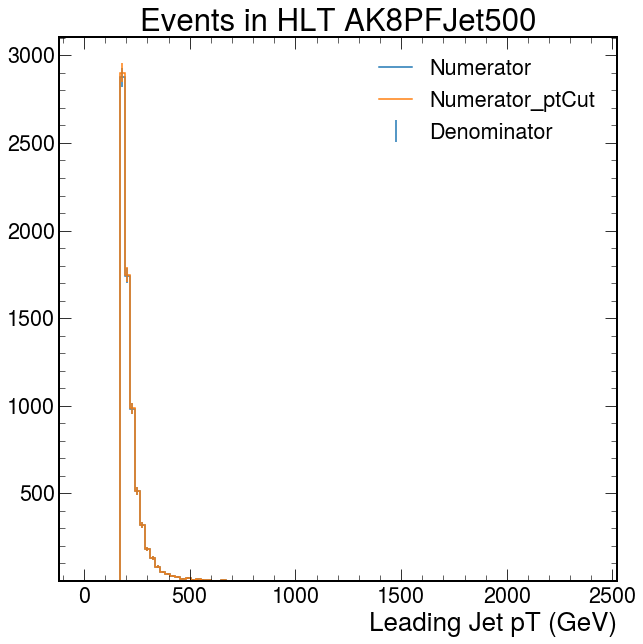

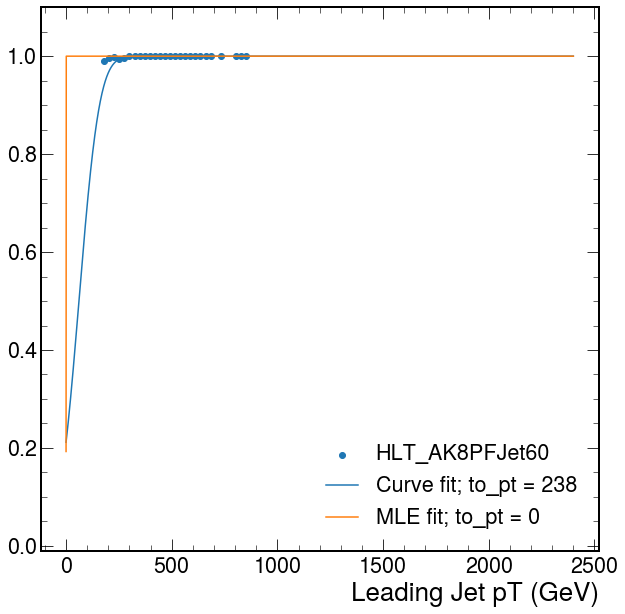

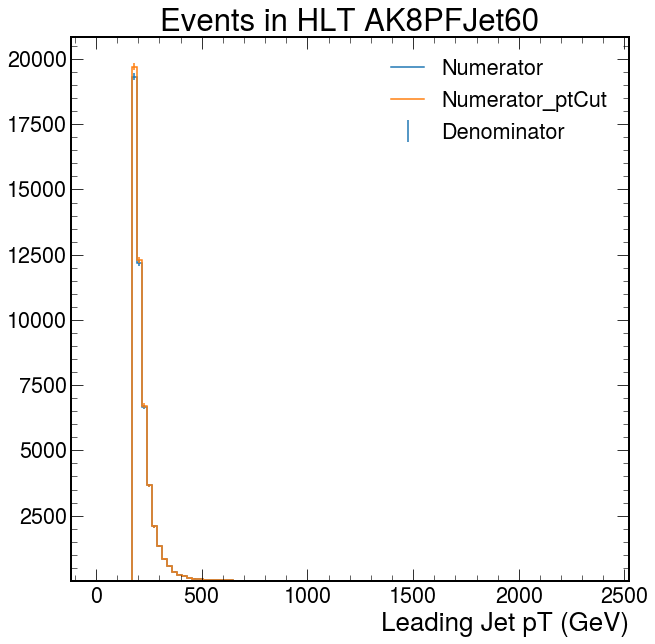

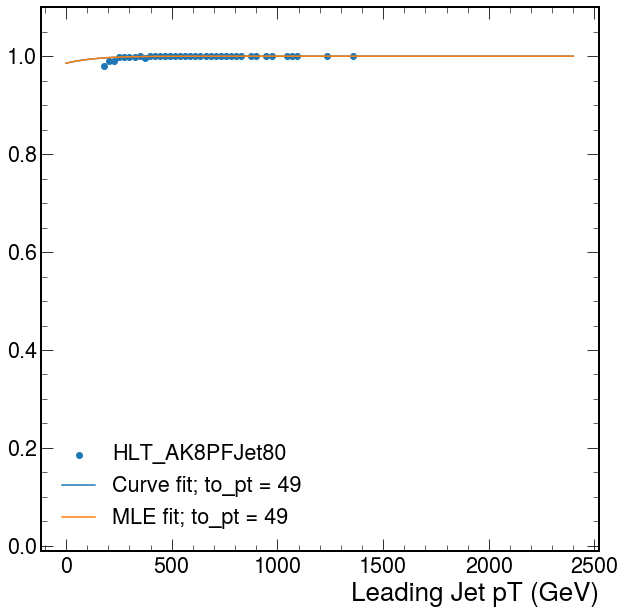

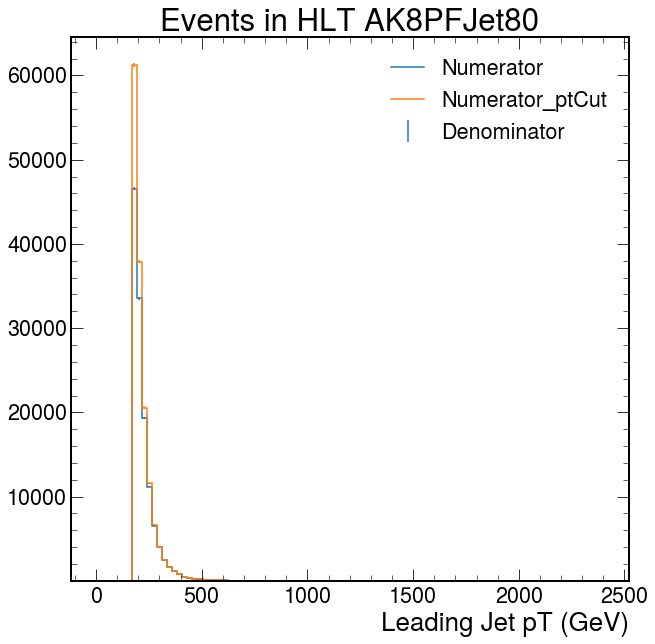

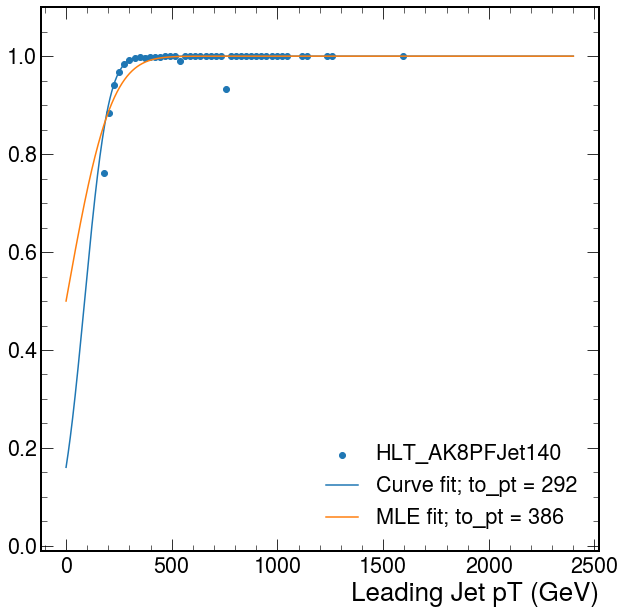

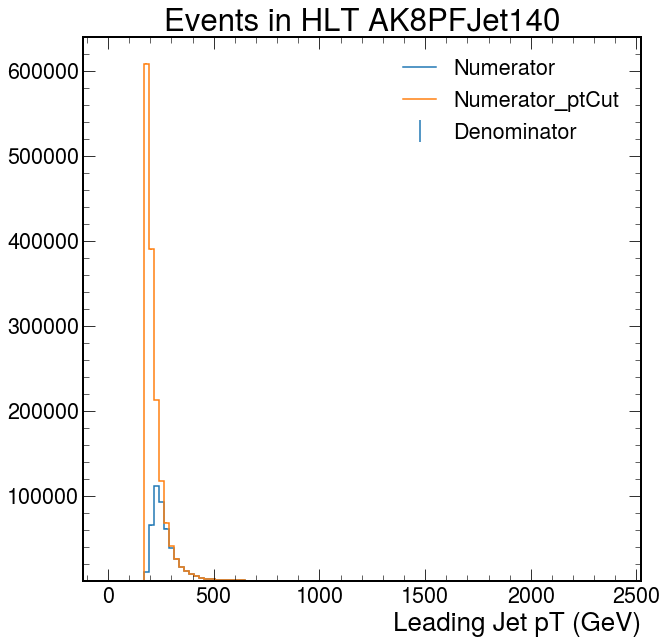

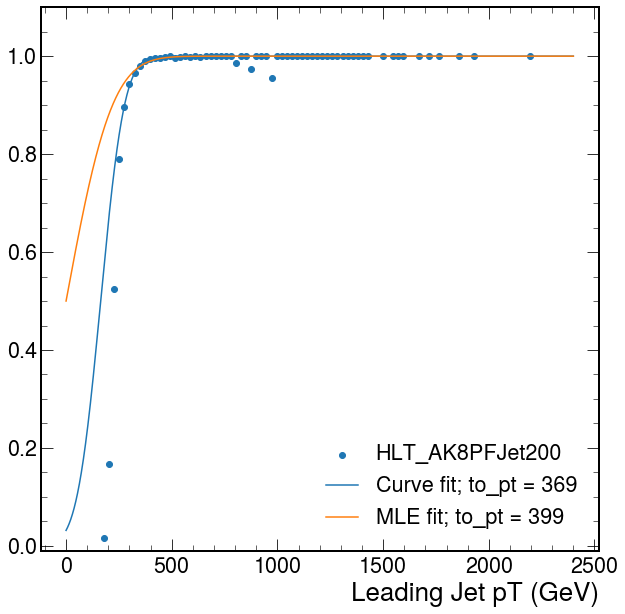

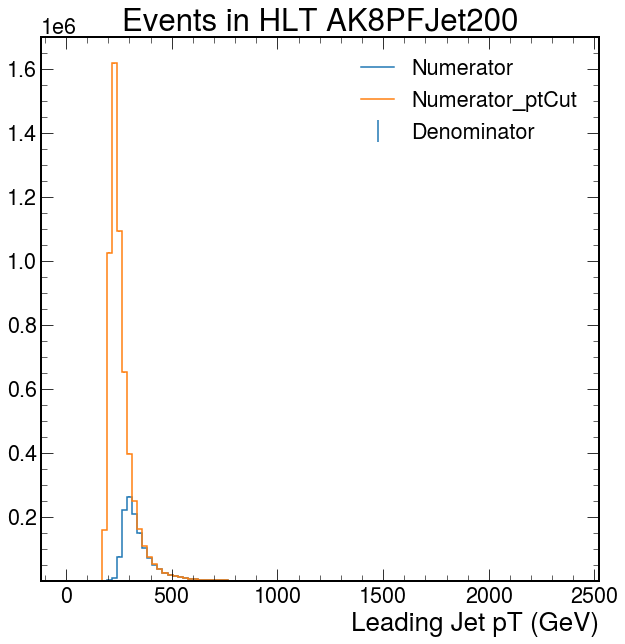

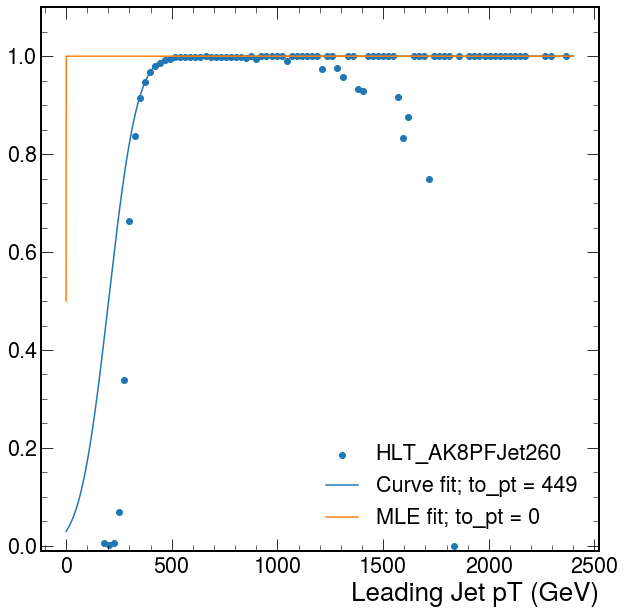

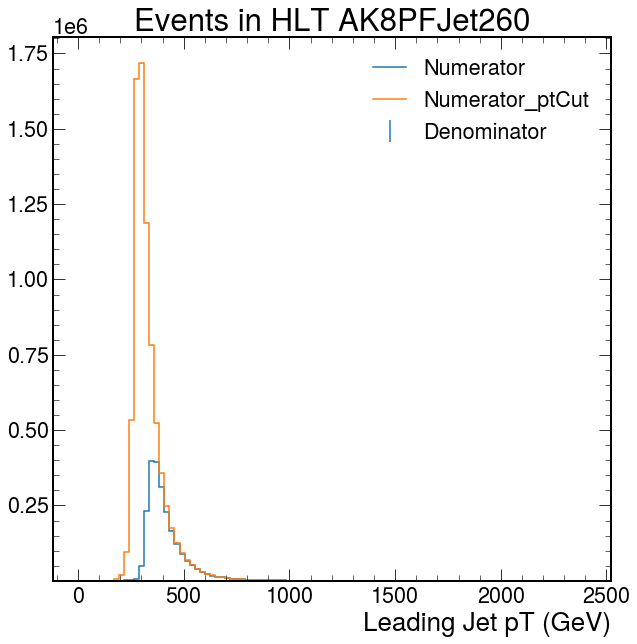

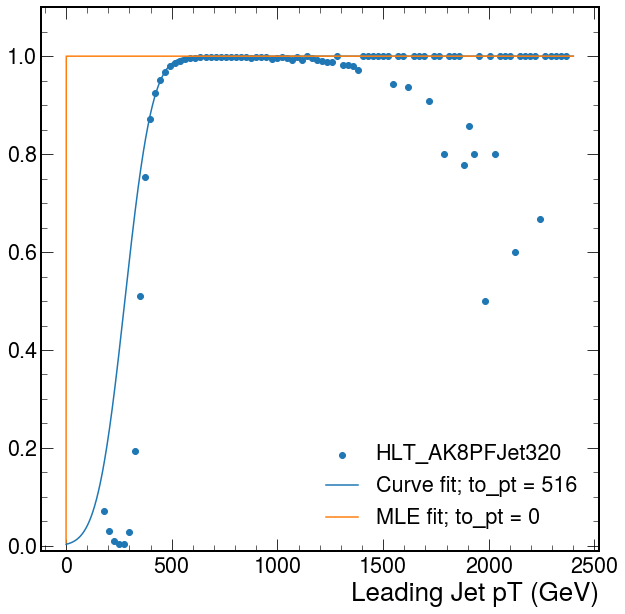

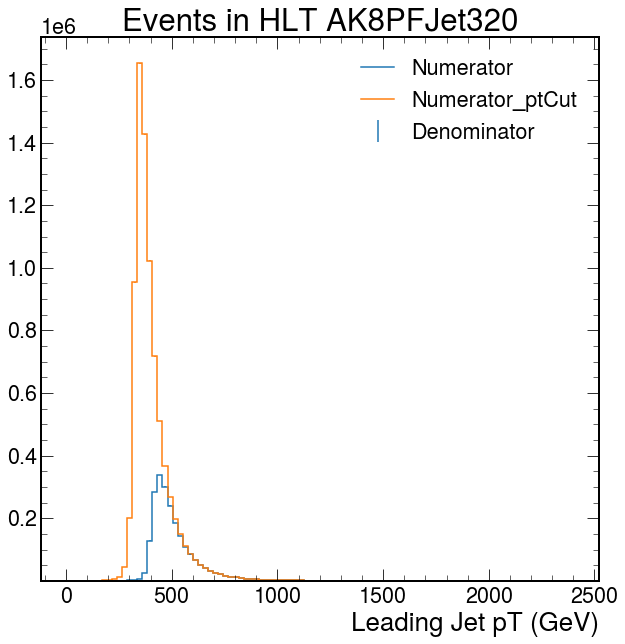

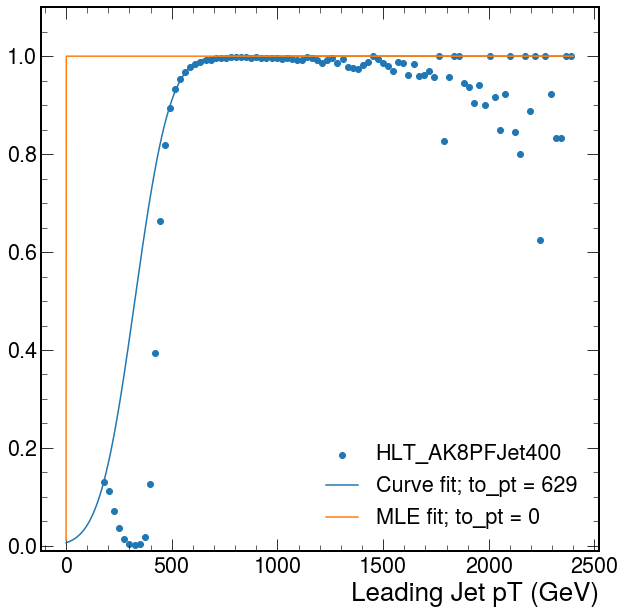

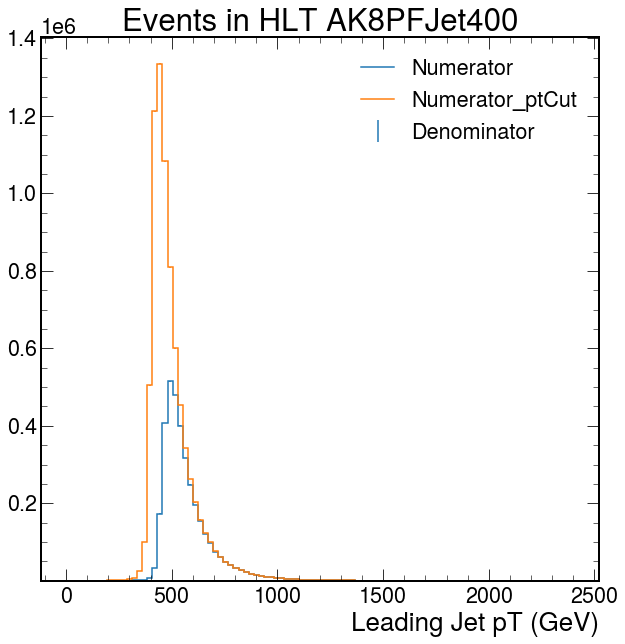

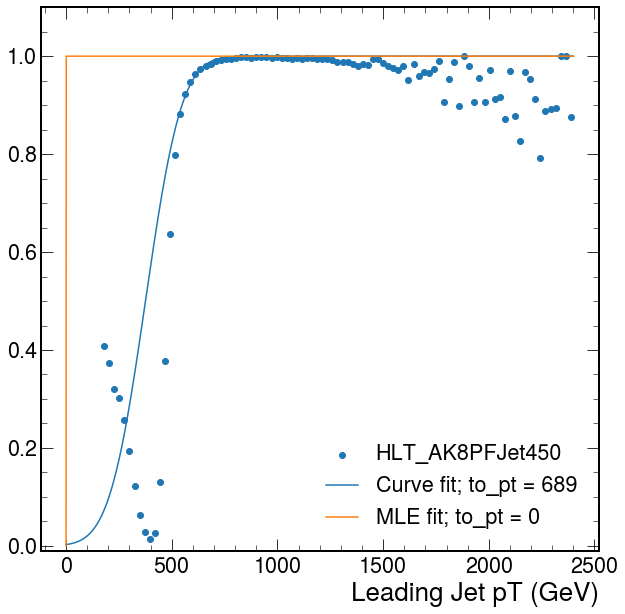

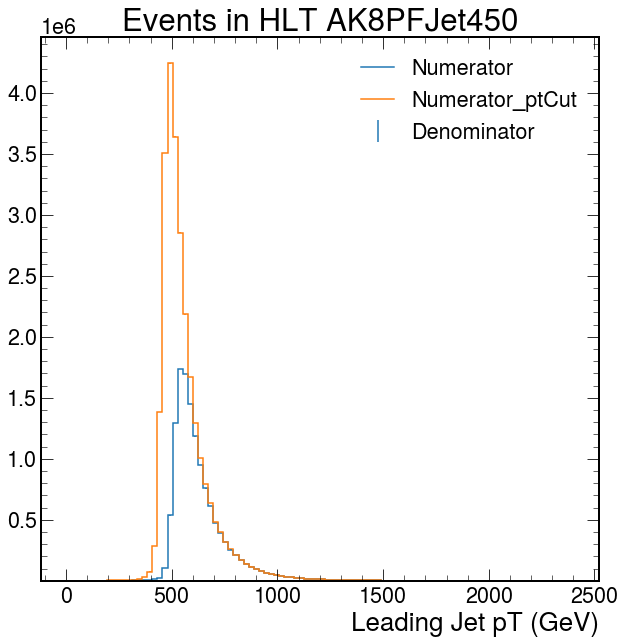

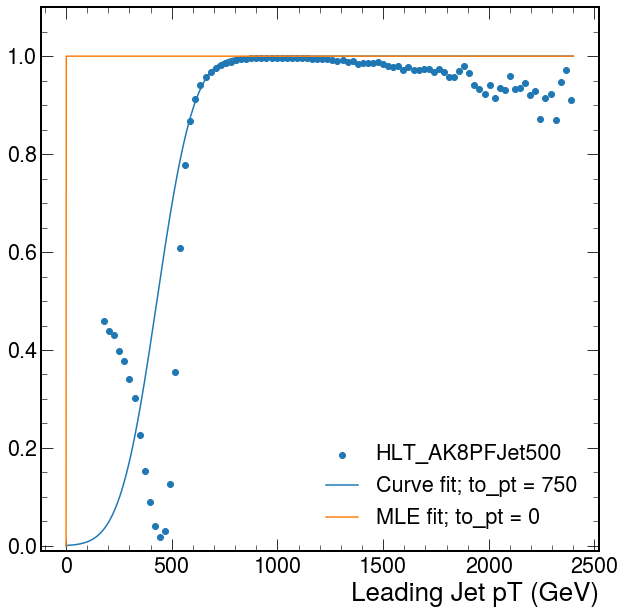

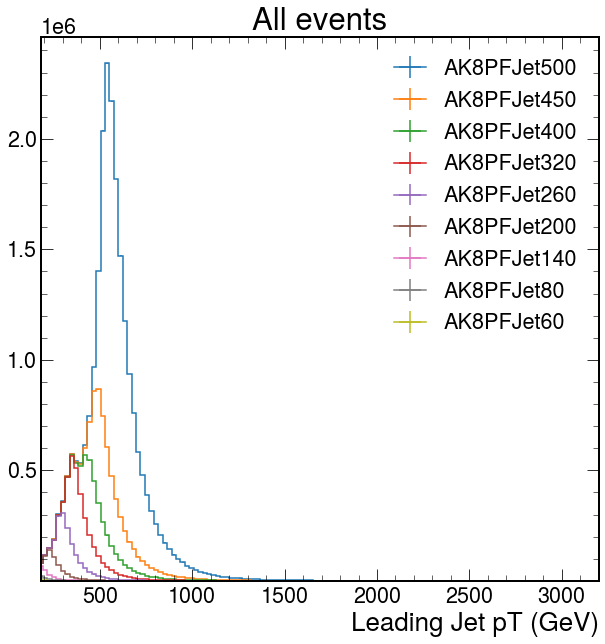

In [5]:
HLT = 'AK8PFJet'
with open("coffeaOutput/triggerAssignment_JetHT_2016APV_AK8PFJet_NewHist.pkl", "rb") as f:
    result = pickle.load( f )
turnOnPts = plot_turnOn(result, HLT)
print(turnOnPts)

In [6]:
# HLT = 'AK8PFJet'
# with open("coffeaOutput/triggerAssignment_QCDsim_2017_AK8PFJet_NewHist.pkl", "rb") as f:
#     result = pickle.load( f )
# turnOnPts = plot_turnOn(result, HLT)
# print(turnOnPts)

In [7]:
# HLT = 'AK8PFJet'
# result = util.load('coffeaOutput/triggerAssignment_QCDsim_2017_AK8PFJet_NewHist.coffea')
# turnOnPts = plot_turnOn(result, HLT)
# print(turnOnPts)

In [8]:
JetHT2016_new = {'AK8PFJet40':0.,
                 'AK8PFJet60': 0., 
                 'AK8PFJet80': 216.73271498356956, 
                 'AK8PFJet140': 288.77775439367343, 
                 'AK8PFJet200': 365.23692713436145, 
                 'AK8PFJet260': 447.2336225160111, 
                 'AK8PFJet320': 514.0097881035936, 
                 'AK8PFJet400': 632.9167920736127, 
                 'AK8PFJet450': 691.0929625368353, 
                 'AK8PFJet500': 750.4349697102186}

JetHT2016APV_new = {'AK8PFJet40':0., 
                     'AK8PFJet60': 0, 
                     'AK8PFJet80': 0, 
                     'AK8PFJet140': 292.4936932484294, 
                     'AK8PFJet200': 368.6063712240707, 
                     'AK8PFJet260': 449.1059028455934, 
                     'AK8PFJet320': 515.8785624883075, 
                     'AK8PFJet400': 628.9385653429788, 
                     'AK8PFJet450': 689.3079407632207, 
                     'AK8PFJet500': 749.695422049344}


JetHT2017_new = {'AK8PFJet40':0.,
                 'AK8PFJet60': 0., 
                 'AK8PFJet80': 0., 
                 'AK8PFJet140': 280.13238125655073, 
                 'AK8PFJet200': 361.66204436543035, 
                 'AK8PFJet260': 448.6491079509249, 
                 'AK8PFJet320': 514.0894465691568, 
                 'AK8PFJet400': 630.6287526399205, 
                 'AK8PFJet450': 685.7915518743982, 
                 'AK8PFJet500': 741.8897640290605, 
                 'AK8PFJet550': 796.7956413028444}

JetHT2018_new = {'AK8PFJet15': 0.,
                 'AK8PFJet25': 0.,
                 'AK8PFJet40': 0.,
                 'AK8PFJet60': 0.,
                 'AK8PFJet80': 0., 
                 'AK8PFJet140': 281.81975103728195, 
                 'AK8PFJet200': 367.6531123322326, 
                 'AK8PFJet260': 458.9796186587356, 
                 'AK8PFJet320': 523.0660904166687, 
                 'AK8PFJet400': 638.7502963687824, 
                 'AK8PFJet450': 689.7766784490543, 
                 'AK8PFJet500': 745.1851326682686, 
                 'AK8PFJet550': 796.7749788024963}



turnOnPts_2016_QCDflat = {'AK8PFJet40':0.,
                          'AK8PFJet60': 106.79400044725446, 
                          'AK8PFJet80': 169.96352855878737, 
                          'AK8PFJet140': 265.2873364497926, 
                          'AK8PFJet200': 315.1712855987987, 
                          'AK8PFJet260': 385.9414264230047, 
                          'AK8PFJet320': 456.1785495557566, 
                          'AK8PFJet400': 528.4054384945691, 
                          'AK8PFJet450': 599.9567915817205, 
                          'AK8PFJet500': 671.8599581978826}

turnOnPts_2017_QCD_flat = {'AK8PFJet40':0.,
                           'AK8PFJet60': 78.72682467365811, 
                           'AK8PFJet80': 114.26008394028244, 
                           'AK8PFJet140': 262.69051582382326, 
                           'AK8PFJet200': 315.5082701033607, 
                           'AK8PFJet260': 391.2706193753585, 
                           'AK8PFJet320': 461.86703035451836, 
                           'AK8PFJet400': 545.2806371181599, 
                           'AK8PFJet450': 611.8168127002015, 
                           'AK8PFJet500': 681.8828608405956, 
                           'AK8PFJet550': 725.799090910656}

turnOnPts_2018_QCDflat = {'AK8PFJet15': 0.,
                          'AK8PFJet25': 0.,
                          'AK8PFJet40': 0.,
                          'AK8PFJet60': 0.,
                          'AK8PFJet80': 0.,
                          'AK8PFJet140': 255.02381002773194, 
                          'AK8PFJet200': 313.2026733979357, 
                          'AK8PFJet260': 388.2175317071178, 
                          'AK8PFJet320': 459.1304096129003, 
                          'AK8PFJet400': 530.7709332894112, 
                          'AK8PFJet450': 599.485074238053, 
                          'AK8PFJet500': 669.532328119605, 
                          'AK8PFJet550': 706.4936306567531}

In [9]:
from plugins import *
from triggerProcessor import *
from dask.distributed import Client


in_year = '2016APV'
data_bool = True
winterfell = True
processor = applyPrescales(year = in_year, trigger = 'AK8PFJet', turnOnPts = np.array(list(JetHT2016APV_new.values())), data = data_bool)
datastring = "JetHT" if processor.data == True else "QCDsim"
if processor.data==False and winterfell:
    filename = "QCD_flat_files.json"
elif processor.data==False:
    filename = "fileset_QCD.json"
else:
    filename = "datasets_UL_NANOAOD.json"
result = runCoffeaJob(processor, jsonFile = filename, winterfell = winterfell, testing = True, year = processor.year, data = processor.data)
with open('coffeaOutput/applyPrescales_{}_{}_{}_NewHist.pkl'.format(datastring, processor.year, processor.trigger), "wb") as f:
    pickle.dump( result, f)

dataset =  /JetHT/Run2016B-ver1_HIPM_UL2016_MiniAODv2_NanoAODv9-v2/NANOAOD
dataset =  /JetHT/Run2016B-ver2_HIPM_UL2016_MiniAODv2_NanoAODv9-v2/NANOAOD
dataset =  /JetHT/Run2016C-HIPM_UL2016_MiniAODv2_NanoAODv9-v2/NANOAOD
dataset =  /JetHT/Run2016D-HIPM_UL2016_MiniAODv2_NanoAODv9-v2/NANOAOD
dataset =  /JetHT/Run2016E-HIPM_UL2016_MiniAODv2_NanoAODv9-v2/NANOAOD
dataset =  /JetHT/Run2016F-HIPM_UL2016_MiniAODv2_NanoAODv9-v2/NANOAOD
Running locally


Preprocessing:   0%|          | 0/6 [00:00<?, ?file/s]

Processing:   0%|          | 0/52 [00:00<?, ?chunk/s]

{'hist_pt': Hist(
  StrCategory(['JetHT'], growth=True, name='dataset', label='Dataset'),
  StrCategory(['AK8PFJet500', 'AK8PFJet450', 'AK8PFJet400', 'AK8PFJet320', 'AK8PFJet260', 'AK8PFJet200', 'AK8PFJet140', 'AK8PFJet80', 'AK8PFJet60', 'AK8PFJet40'], growth=True, name='HLT_cat', label='HLT_cat'),
  Regular(1000, 0, 2400, name='pt', label='Jet pT (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=930100, variance=930100) (WeightedSum(value=930207, variance=930207) with flow), 'hist_pt_byHLTpath': Hist(
  StrCategory(['JetHT'], growth=True, name='dataset', label='Dataset'),
  StrCategory(['AK8PFJet500', 'AK8PFJet450', 'AK8PFJet400', 'AK8PFJet320', 'AK8PFJet260', 'AK8PFJet200', 'AK8PFJet140', 'AK8PFJet80'], growth=True, name='HLT_cat', label='HLT_cat'),
  Regular(1000, 0, 2400, name='pt', label='Jet pT (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=6.26816e+07, variance=2.18256e+12) (WeightedSum(value=6.26817e+07, variance=2.18256e+12) with flow), 'cutflow': defaultdict_accumu

In [10]:
def plotPrescales(result, year):
    hist_pt = result['hist_pt'][{'dataset':sum}]
    hist_pt_byHLTpath = result['hist_pt_byHLTpath'][{'dataset':sum}]
    plt.rcParams['figure.facecolor']='white'
    plt.rcParams["figure.figsize"] = (20,10)
    fig, axs = plt.subplots(1, 2)      
    print(hist_pt)

    hist_pt.plot1d(ax = axs[0], overlay='HLT_cat')
    axs[0].set_yscale('log')
    axs[0].set_ylim([0.0, 1.0e10])
    axs[0].set_title('Events sorted by HLT w/ prescale applied')

    hist_pt_byHLTpath.plot1d(ax = axs[1], overlay='HLT_cat')
    axs[1].set_yscale('log')
    axs[1].set_ylim([1.0e-1, 1.0e10])
    axs[1].set_title('Doubles removed w/ prescale applied')

    fig.suptitle('Apply Prescales ' + str(year), fontsize="large")

    plt.rc('legend',fontsize='small')
    plt.legend()
    dataset = 'JetHT' + str(year)
    os_path = 'plots/triggerStudies'+ dataset + '/'
    checkdir(os_path)
    plt.savefig(os_path + 'applyPrescales' + str(year) + ".png")


[930207.]
Hist(
  StrCategory(['AK8PFJet500', 'AK8PFJet450', 'AK8PFJet400', 'AK8PFJet320', 'AK8PFJet260', 'AK8PFJet200', 'AK8PFJet140', 'AK8PFJet80', 'AK8PFJet60', 'AK8PFJet40'], growth=True, name='HLT_cat', label='HLT_cat'),
  Regular(1000, 0, 2400, name='pt', label='Jet pT (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=930100, variance=930100) (WeightedSum(value=930207, variance=930207) with flow)


/tmp/ipykernel_3732/3040487494.py:11: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axs[0].set_ylim([0.0, 1.0e10])


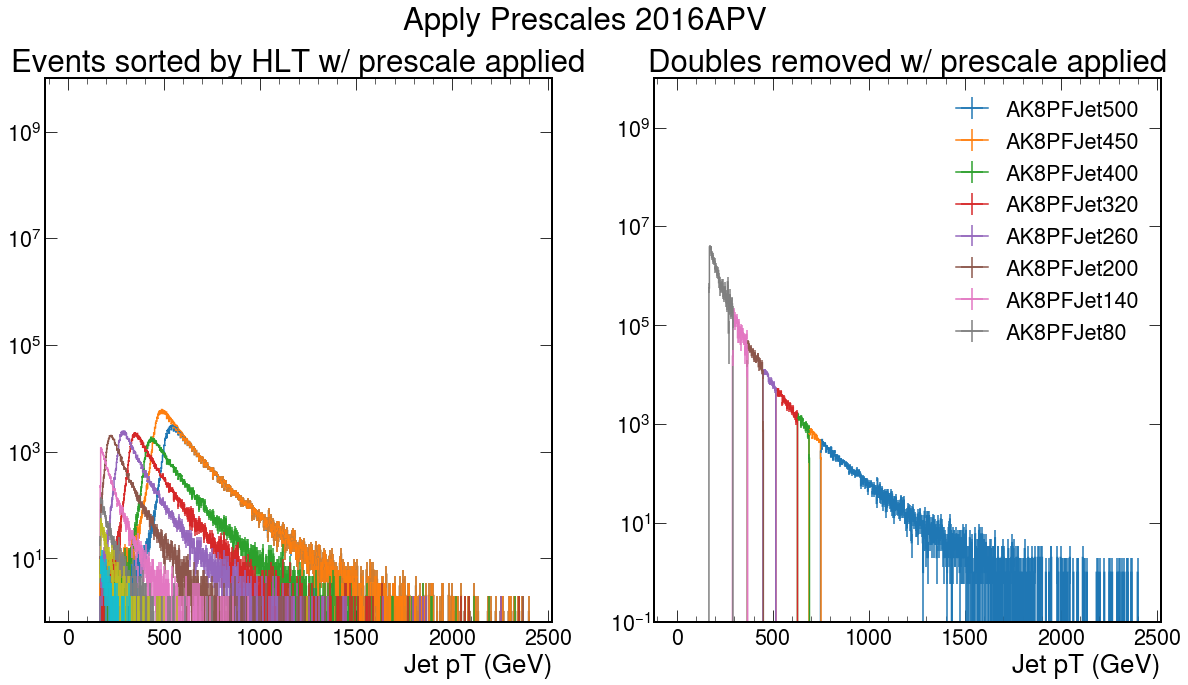

In [11]:
with open("coffeaOutput/applyPrescales_JetHT_2016APV_AK8PFJet_NewHist.pkl", "rb") as f:
    result = pickle.load( f )
print(result['hist_pt'][{'HLT_cat':sum, 'pt':sum}].values())
plotPrescales(result, '2016APV')

[32928555.]
Hist(
  StrCategory(['AK8PFJet500', 'AK8PFJet450', 'AK8PFJet400', 'AK8PFJet320', 'AK8PFJet260', 'AK8PFJet200', 'AK8PFJet140', 'AK8PFJet80', 'AK8PFJet60', 'AK8PFJet40'], growth=True, name='HLT_cat', label='HLT_cat'),
  Regular(1000, 0, 2400, name='pt', label='Jet pT (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=3.29269e+07, variance=3.29269e+07) (WeightedSum(value=3.29286e+07, variance=3.29286e+07) with flow)


/tmp/ipykernel_3732/3040487494.py:11: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axs[0].set_ylim([0.0, 1.0e10])


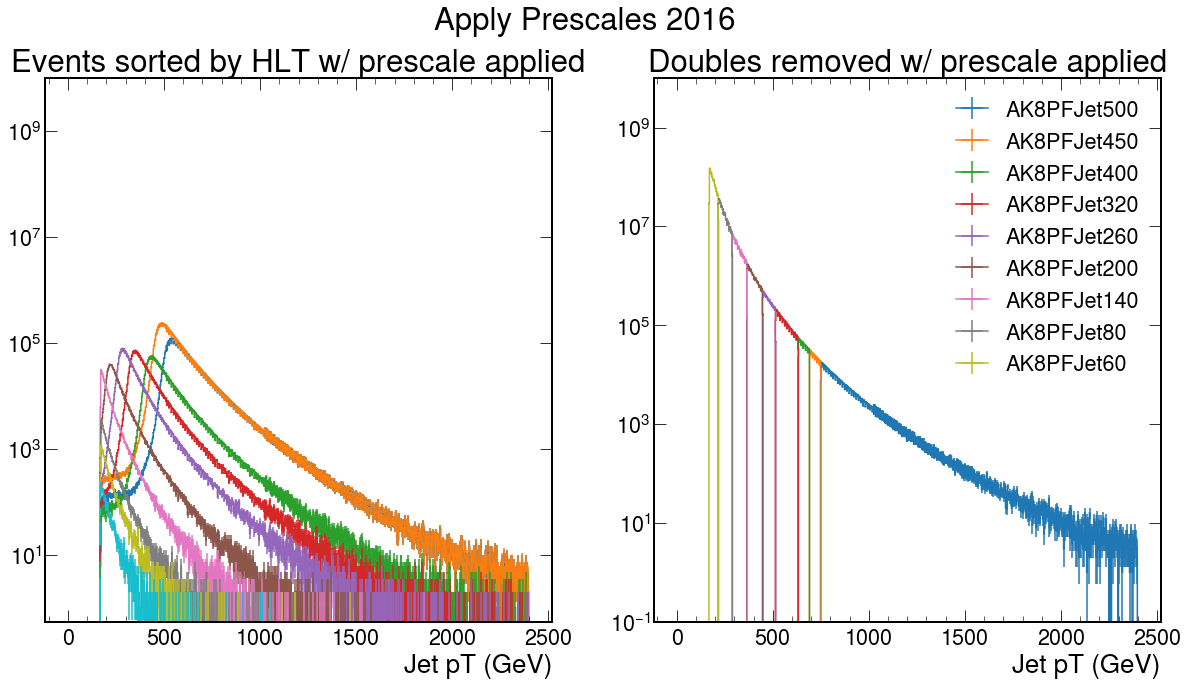

In [12]:
with open("coffeaOutput/applyPrescales_JetHT_2016_AK8PFJet_NewHist.pkl", "rb") as f:
    result = pickle.load( f )
print(result['hist_pt'][{'HLT_cat':sum, 'pt':sum}].values())
plotPrescales(result, '2016')

In [13]:
with open("coffeaOutput/applyPrescales_JetHT_2017_AK8PFJet_NewHist.pkl", "rb") as f:
    result = pickle.load( f )
# print(result['hist_pt'][{'HLT_cat':sum, 'pt':sum}].values())
plotPrescales(result, '2017')

SyntaxError: EOL while scanning string literal (2433034269.py, line 4)

In [ ]:
with open("coffeaOutput/applyPrescales_JetHT_2018_AK8PFJet_NewHist.pkl", "rb") as f:
    result = pickle.load( f )
# print(result['hist_pt'][{'HLT_cat':sum, 'pt':sum}].values())
plotPrescales(result, '2018')